### A simple CNN for classifying the CIFAR-10 dataset
##### Again we show some sample images with their classification results.

### Step 1: Import Necessary Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Step 2: Load and Normalize the CIFAR-10 Dataset

In [ ]:
# Define the transformations to apply to the data
# mean, std = torch.tensor([0.4914, 0.4822, 0.4465]), torch.tensor([0.2023, 0.1994, 0.2010])
mean, std = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean, std)])

# Load the CIFAR-10 training and test datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170498071/170498071 [00:13<00:00, 12927642.99it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Step 3: Define the CNN Model

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) # 0: H --> 32->30(conv) --> 15(pool) --> 13(conv) -->6
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 8 * 8, 512) # H(32)-3+2+1=H; H/2/2=8
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8) # x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def reset_weights(self):
        # Reset the weights by calling the initialization again
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                m.reset_parameters()  # This calls the default initialization for the layer

net = SimpleCNN().to(device)


### Step 4: Define the Loss Function and Optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


### Step 5 (version A): Train the CNN

In [ ]:
for epoch in range(5):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

print('Finished Training')


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[Epoch 1, Batch 200] loss: 2.238
[Epoch 1, Batch 400] loss: 1.973
[Epoch 2, Batch 200] loss: 1.728
[Epoch 2, Batch 400] loss: 1.629
[Epoch 3, Batch 200] loss: 1.510
[Epoch 3, Batch 400] loss: 1.444
[Epoch 4, Batch 200] loss: 1.370
[Epoch 4, Batch 400] loss: 1.348
[Epoch 5, Batch 200] loss: 1.283
[Epoch 5, Batch 400] loss: 1.271
Finished Training


### Step 6: Test the Network and Display Sample Results

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([3, 36, 274])


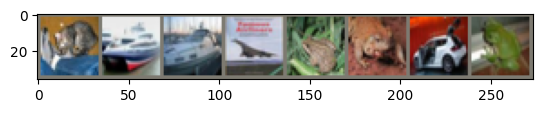

GroundTruth:	 cat    ship   ship   plane  frog   frog   car    frog  
Predicted:	 cat    ship   ship   ship   deer   frog   car    deer  


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)
# images, labels = images.to(device), labels.to(device)

# mean, std = torch.tensor([0.4914, 0.4822, 0.4465]), torch.tensor([0.2023, 0.1994, 0.2010])

# Print images and ground truth labels
def imshow(imgs):
    print(imgs.shape) # std.shape, mean.shape: tuple has no shape
    for i in range(3):
      imgs[i] = imgs[i] * std[i] + mean[i]
    plt.imshow(imgs.permute(1, 2, 0)) # H, W, C # np.transpose(imgs.numpy(), (1,2,0))
    plt.show()

# Display sample images with ground truth labels
imshow(torchvision.utils.make_grid(images[:8])) # C, H, W
print('GroundTruth:\t', ' '.join(f'{classes[labels[j]]}'.ljust(6) for j in range(8)))

# Predict the labels for the sample images
images = images.to(device) # because net is on GPU
outputs = net(images[:8])
_, predicted = torch.max(outputs, 1)
print('Predicted:\t', ' '.join(f'{classes[predicted[j]]}'.ljust(6) for j in range(8)))


## Version B: plot loss and accuracy curves

In [ ]:
net.reset_weights()

### Step 5 (version B): Train the CNN and Record Loss and Accuracy

In [ ]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

net = net.to(device)
for epoch in range(5):  # loop over the dataset multiple times
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(trainloader))
    train_accuracies.append(100 * correct / total)

    net.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_losses.append(test_loss / len(testloader))
    test_accuracies.append(100 * correct / total)

    print(f'[Epoch {epoch + 1}] Training loss: {train_losses[-1]:.3f}, Training accuracy: {train_accuracies[-1]:.2f}%')
    print(f'Test loss: {test_losses[-1]:.3f}, Test accuracy: {test_accuracies[-1]:.2f}%')

print('Finished Training')


[Epoch 1] Training loss: 2.068, Training accuracy: 26.17%
Test loss: 1.831, Test accuracy: 34.90%
[Epoch 2] Training loss: 1.696, Training accuracy: 40.56%
Test loss: 1.578, Test accuracy: 44.65%
[Epoch 3] Training loss: 1.478, Training accuracy: 48.03%
Test loss: 1.399, Test accuracy: 50.80%
[Epoch 4] Training loss: 1.340, Training accuracy: 52.52%
Test loss: 1.302, Test accuracy: 53.98%
[Epoch 5] Training loss: 1.254, Training accuracy: 55.53%
Test loss: 1.244, Test accuracy: 56.16%
Finished Training


### Step 6 (version B): Plot Loss and Accuracy Curves

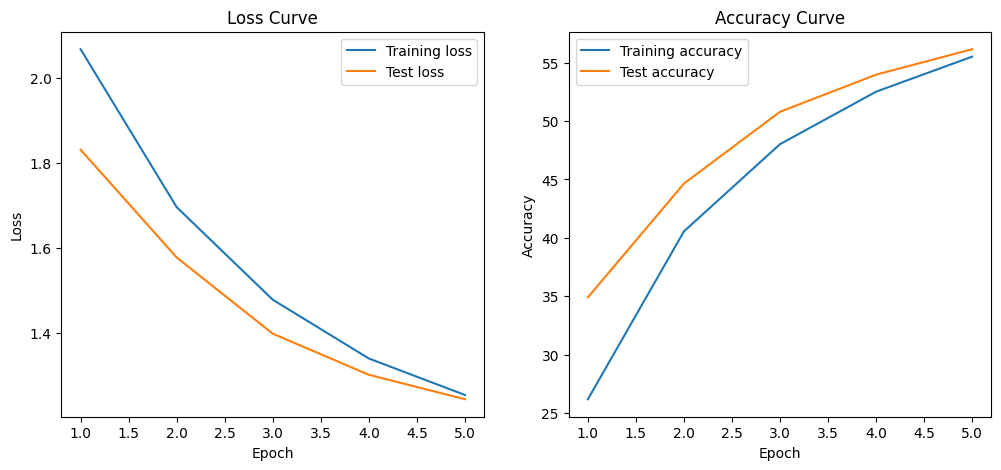

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, 6)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training loss')
plt.plot(epochs, test_losses, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training accuracy')
plt.plot(epochs, test_accuracies, label='Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()
